In [1]:
# import modules
import pandas as pd
import numpy as np

import string
import re
import csv
import nltk
from nltk.corpus import stopwords

from gensim.models import word2vec
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer


# Clean up dataframe 

In [30]:
# get list of tech skills and their industry demand
tech_skills_full = pd.read_csv('Hot_Technologies_Software_Developer_ONET.csv')
# only keep 'trending' skills, where 'in demand' b== Yes
tech_skills = tech_skills_full.loc[tech_skills_full['In Demand'] == 'Yes']
# remove redudant 'software' for some skills and remove periods
tech_skill_names = tech_skills['Technology Skill'].apply(lambda x: x.lower().replace('software',''))
tech_skill_names = tech_skill_names.apply(lambda x: x.replace('.','')).to_list()
# strip trailing spaces and replace intermediate spaces with '_'
# tech_skill_names = [skill.strip(' ').replace(' ','_') for skill in tech_skill_names]
tech_skill_names = [skill.strip(' ') for skill in tech_skill_names]
# print skills and show original df
print(tech_skill_names)
tech_skills_full


['oracle java', 'structured query language sql', 'javascript', 'python', 'amazon web services aws', 'c#', 'microsoft azure', 'git', 'google angular', 'react', 'cascading style sheets css', 'docker', 'linux', 'c++', 'kubernetes', 'hypertext markup language html', 'jenkins ci', 'nodejs', 'nosql', 'microsoft net framework', 'atlassian jira', 'spring framework', 'c', 'extensible markup language xml', 'javascript object notation json', 'apache kafka', 'spring boot', 'typescript', 'postgresql', 'microsoft sql server', 'unix']


,Percentage,Technology Skill,In Demand
0,32,Oracle Java,Yes
1,26,Structured query language SQL,Yes
2,24,JavaScript,Yes
3,23,Python,Yes
4,22,Amazon Web Services AWS software,Yes
...,...,...,...
137,0,Adobe Systems Adobe Acrobat,NaN
138,0,Google Sheets,NaN
139,0,Oracle Primavera Enterprise Project Portfolio ...,NaN
140,0,LinkedIn,NaN


In [31]:
# get list of soft skills and their clusters
soft_skills = pd.read_csv('soft_skills.csv')
soft_skill_names = soft_skills['skill_name']
# print soft skills and show original df
print(soft_skill_names)
soft_skills


0           ability to working with groups of people
1                                      people skills
2            ability to work effectively with people
3                                    people oriented
4                        ability to work with people
                           ...                      
825                  ability to respond to questions
826                       ability to make trade offs
827                   ability to overcome challenges
828                                  forward thinker
829    able to drive important projects successfully
Name: skill_name, Length: 830, dtype: object


,skill_name,cluster_id,cluster_representative
0,ability to working with groups of people,0,people skills
1,people skills,0,people skills
2,ability to work effectively with people,0,people skills
3,people oriented,0,people skills
4,ability to work with people,0,people skills
...,...,...,...
825,ability to respond to questions,185,ability to respond to questions
826,ability to make trade offs,186,ability to make trade offs
827,ability to overcome challenges,187,ability to overcome challenges
828,forward thinker,188,forward thinker


In [9]:
# load in scraped job files and combine into one df

# set the file path for scraped jobs 
file_path = 'swe_us_ft_4wks_041923.csv'
# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
df['description'] = df['descriptions']
df = df.drop('descriptions', axis=1)

file_path = 'swe_us_ft_4wks_050323.csv'
df2 = pd.read_csv(file_path)

df = pd.concat([df,df2],axis=0).drop('link', axis=1).reset_index(drop=True)

df


,title,company,location,salary,description
0,Software Engineer,Mavis Discount Tire,"Millwood, NY 10546","$100,000 - $130,000 a year",Mavis Discount Tire - Software Engineer\nMavis...
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,"Dulles, VA","$150,000 - $200,000 a year","Recro is looking for a motivated, career and c..."
2,Sr. Software Engineer | MES Solutions,RedViking,"Hybrid remote in Plymouth, MI 48170",Estimated $119K - $150K a year,Description:Are you ready to leverage new tech...
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,"Hybrid remote in Southborough, MA 01772","$150,000 - $200,000 a year",Block Engineering is a leading developer of la...
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,"Melbourne, FL 32935",$16 - $19 an hour,"We are a growing team of top-notch, innovative..."
...,...,...,...,...,...
186,Associate Software Engineer (Hybrid or Remote),Moody's,"Remote in Edinburgh, IN","$64,600 - $110,400 a year",The Full-Stack Web Developer will be part of a...
187,CONTRACT - Associate Software Engineer (NST),Nintendo,"Hybrid remote in Redmond, WA",$30 - $50 an hour,Nintendo Software Technology Corporation\nNint...
188,Entry Level Software Developer,BeaconFire Solution,"Princeton, NJ","$60,000 - $80,000 a year",Entry-level Software Developer\nBeaconFire Cor...
189,Full-Stack Software Engineer,Mastech Digital,Remote,$55 - $60 an hour,"s Fluency in node.js (specifically koa.js), vu..."


In [10]:
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [11]:

# find type of work (remote, hybrid, or inperson) and state if applicable
work_week = []

for loc in df['location']:
#     print(loc)
    # find pair of consecutive upper case chars that is 
    # not preceded or followed by another upper case; 'ABC City, AL' --> 'AL'
    state_match = re.findall(r'(?<![A-Z])[A-Z]{2}(?![A-Z])', loc)
    
    # first look for 'hybrid' in 'hybrid remote' or 'hybrid'
    if 'hybrid' in loc.lower():
        job_type = 'hybrid'
    # if fully remote
    elif 'remote' in loc.lower():
        job_type = 'remote'
        state_match = ['remote']
    # else assume in-person
    else:
        job_type = 'in-person'
    
    # if only state name given and not a city, find abbreviation from dict
    if state_match: 
        work_week.append((job_type,state_match[0]))
    elif loc in states_dict:
        work_week.append((job_type,states_dict[loc]))
    
df['type'], df['location'] = zip(*work_week)

# reformat salary column to avg annual
hrs_per_year = 40*52
salary = []

for s in df['salary']:
    if type(s) == str and any(ch.isdigit() for ch in s):
        # match instance of '$' followed by digits and commas
        pattern = r'\$([\d,]*)'
        # extract the lower and upper bound of the salary range
        match = re.findall(pattern, s.replace(',',''))
        # adjust to annual
        avg_salary = sum([int(m) for m in match])/len(match)
        if 'an hour' in s:
            avg_salary = avg_salary*hrs_per_year
        if 'month' in s:
            avg_salary = avg_salary*12
        if 'Estimated' in s:
            avg_salary = avg_salary*1000
        
    salary.append(avg_salary)

df['salary'] = salary

states = pd.Series(states_dict.values())

annual_mean_wage = pd.read_csv('mean_annual_salary_swe.csv').drop(
                                index=[39] + list(range(52, 57))).reset_index(drop=True)
annual_mean_wage['Area Name'] = pd.Series(states)

# get US mean salary then convert state salary stats to dict with {state:avg_salary}
us_avg_salary = round(annual_mean_wage['Annual mean wage'].mean(), 0)
annual_mean_wage = dict(zip(annual_mean_wage.iloc[:,0],annual_mean_wage.iloc[:,1]))

# calculate salary difference in comparison to location average
salary_delta = []
for i,location in enumerate(df['location']):
    salary = df['salary'][i]
    # if salary is known
    if type(salary) != 'str':
        # if remote, take difference from US average, else use state average
        if location != 'remote':
            salary_delta.append(salary - annual_mean_wage[location])
        else:
            salary_delta.append(salary - us_avg_salary)
    else:
        salary_delta.append(salary)

df['salary_delta'] = salary_delta
df


,title,company,location,salary,description,type,salary_delta
0,Software Engineer,Mavis Discount Tire,NY,115000.0,Mavis Discount Tire - Software Engineer\nMavis...,in-person,-14950.0
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,"Recro is looking for a motivated, career and c...",in-person,47170.0
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,Description:Are you ready to leverage new tech...,hybrid,36770.0
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,Block Engineering is a leading developer of la...,hybrid,46810.0
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,"We are a growing team of top-notch, innovative...",in-person,-68800.0
...,...,...,...,...,...,...,...
186,Associate Software Engineer (Hybrid or Remote),Moody's,remote,87500.0,The Full-Stack Web Developer will be part of a...,remote,-20482.0
187,CONTRACT - Associate Software Engineer (NST),Nintendo,WA,83200.0,Nintendo Software Technology Corporation\nNint...,hybrid,-61950.0
188,Entry Level Software Developer,BeaconFire Solution,NJ,70000.0,Entry-level Software Developer\nBeaconFire Cor...,in-person,-54100.0
189,Full-Stack Software Engineer,Mastech Digital,remote,119600.0,"s Fluency in node.js (specifically koa.js), vu...",remote,11618.0


In [12]:

# join job descriptions into one corpus
corpus = '\n'.join(df['description'])
# separate into sentences
docs = corpus.split('\n')

punct = (string.punctuation).replace('#','').replace('+','')

# clean sentences and output nested list of sentence unigrams
sentences=[ [token.strip(punct).strip()                        # strip punctuation and leading/trailing spaces 
                 for token in nltk.word_tokenize(
                     doc.replace('-',' ').replace('/',' ').replace('.','').lower())  # make lowercase and convert to unigrams
                 if token not in punct and                     # drop punctuation tokens
                 len(token)>=2]                                # only keep tokens at least 2 characters 
             for doc in docs]                                  # iterate through each sentence in corpus of all descriptions

sentences = [sent for sent in sentences if len(sent) > 0]



# Use cleaned sentences to train Word2Vec model for tech skills

In [16]:
sentences_strings = [' '.join(sentence) for sentence in sentences]

# Create a CountVectorizer instance and fit_transform the sentences
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(sentences_strings)

# Get the feature names (i.e., terms) from the vectorizer
tokens = vectorizer.get_feature_names_out()

tdf_dict = {}

for token in tokens:
    count = sum(1 for sentence in sentences if token in sentence)
    tdf_dict[token] = count
    
    

In [13]:
# print out tracking information
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)

model = word2vec.Word2Vec(sentences, \
            min_count=1,vector_size=100, \
            window=5, workers=4, sg=1 )



2023-05-03 21:52:47,814 : INFO : collecting all words and their counts
2023-05-03 21:52:47,815 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-05-03 21:52:47,835 : INFO : collected 6985 word types from a corpus of 92290 raw words and 6592 sentences
2023-05-03 21:52:47,836 : INFO : Creating a fresh vocabulary
2023-05-03 21:52:47,864 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 6985 unique words (100.00% of original 6985, drops 0)', 'datetime': '2023-05-03T21:52:47.864332', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-05-03 21:52:47,865 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 92290 word corpus (100.00% of original 92290, drops 0)', 'datetime': '2023-05-03T21:52:47.865333', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by conda-forge | (main, Jan 

In [20]:
# check what tokens from the skills list are not in vocab
skill_alias = {}

for skills in tech_skill_names:
    skill_tokens = skills.split()
    for skill in skill_tokens:
        if skill not in tdf_dict:
#             print(skill, skills.split())
            skill_alias[skills] = skill_tokens[-1]
            
cleaned_tech_skills = [skill_alias.get(skill, skill) for skill in tech_skill_names]
cleaned_tech_skills[1] = 'sql'
# cleaned_tech_skills.extend(['postgres','agile'])
print(cleaned_tech_skills)

n_terms = 20

for skills in cleaned_tech_skills:
    skill = skills.split()
    if any(word in model.wv.key_to_index for word in skill):
        print(f"Top {n_terms} words similar to word {skill}:\n \
        {model.wv.most_similar(skill, topn=n_terms)}\n")
  
    else:
        print(f'{skill} not in model vocabulary.\n')
        

['oracle java', 'sql', 'javascript', 'python', 'amazon web services aws', 'c#', 'microsoft azure', 'git', 'google angular', 'react', 'css', 'docker', 'linux', 'c++', 'kubernetes', 'html', 'jenkins ci', 'nodejs', 'nosql', 'microsoft net framework', 'atlassian jira', 'spring framework', 'c', 'extensible markup language xml', 'json', 'apache kafka', 'spring boot', 'typescript', 'postgresql', 'microsoft sql server', 'unix']
Top 20 words similar to word ['oracle', 'java']:
         [('spring', 0.9949577450752258), ('rest', 0.9911128878593445), ('preferably', 0.9910634160041809), ('nodejs', 0.9888002872467041), ('typescript', 0.9886518716812134), ('php', 0.9879885315895081), ('scripting', 0.9869400858879089), ('linux', 0.9868445992469788), ('angular', 0.9867959022521973), ('mongodb', 0.9850236773490906), ('framework', 0.9845933318138123), ('android', 0.9844111800193787), ('aspnet', 0.9843462109565735), ('nosql', 0.982799768447876), ('microsoft', 0.9818916916847229), ('jquery', 0.981670856475

# Clustering based on word embedding model

In [67]:

sentence_vectors = []
for tokenized_sentence in sentences:
        vectorized_sentence = [model.wv[word] for word in tokenized_sentence if word in model.wv.index_to_key]
        sentence_vector = sum(vectorized_sentence) / len(vectorized_sentence)
        sentence_vectors.append(sentence_vector)

# Apply K-means clustering to the sentence vectors
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=20)
kmeans.fit(sentence_vectors)

# Extract the sentences that belong to each cluster
clusters = [[] for i in range(num_clusters)]
for i, label in enumerate(kmeans.labels_):
    clusters[label].append(sentences[i])

# Obtain the top words for each cluster
num_top_words = 20
top_words = {i:None for i in range(num_clusters)}

for i in range(num_clusters):
    # get cluster centroids
    centroid = kmeans.cluster_centers_[i]
    # get angle between centroid and word embedding vectors
    similarity_scores = cosine_similarity([centroid], model.wv.vectors)
    # find top words for each cluster and add to list
    top_word_indices = np.argsort(similarity_scores[0])[::-1][:num_top_words]
    # update dict value for the cluster
    cluster_words = [model.wv.index_to_key[j] for j in top_word_indices]
    top_words[i] = cluster_words
    # Print the top words for each cluster
    print(f"Cluster {i}: {cluster_words}")   


Cluster 0: ['ultimately', 'step', 'yourself', 'connected', 'extensive', 'minds', 'pushing', 'bigcommerce', 'space', 'bay', 'founding', 'jomashop', 'experts', 'model', 'gametime', 'almost', 'outside', 'my', 'path', 'play']
Cluster 1: ['demonstrated', 'proven', 'solid', '1+', 'previous', 'deep', '5+', '3+', 'skill', 'computing', 'typically', 'microsoft', 'plc', 'ruby', 'qa', 'oop', 'devops', 'disciplines', 'structures', 'fundamentals']
Cluster 2: ['dental', 'savings', 'account', 'spending', 'plan', 'retirement', 'wellness', 'vision', 'coverage', '401', 'comprehensive', '401k', 'matching', 'hsa', 'insurance', 'tuition', 'premiums', 'long', 'fsa', 'short']


In [68]:
# get number of sentences per posting
lengths = []
for d in df['description']:
    d = d.split('\n')
    lengths.append(len(d))

# choose tech skills cluster based on top words
tech_skills_cluster = clusters[1]

# make skill names concise and drop extraneous tokens
cleaned_tech_skills[4] = 'aws'
unique_skills = []
for skills in cleaned_tech_skills:
    unique_skills.extend(skills.split())

drop_words = ['google','microsoft','framework','server']
unique_skills = [skill for skill in unique_skills if skill not in drop_words]

sent_skills = {}
# find skills that appear in the cluster of tech skills
for i,sent in enumerate(tech_skills_cluster):
    found = []
    for skills in unique_skills:
        if skills in sent:
            found.append(skills)
    
    sent_skills[i] = found

    
doc_skills = {}
# map cluster item skills to sentence index
for i,cluster_item in enumerate(tech_skills_cluster):
    for j,sent in enumerate(sentences):
        if len(sent_skills[i])>0 and sent == cluster_item:
            doc_skills[j] = sent_skills[i]

indices = list(sorted(doc_skills.keys()))
# Assign the indices to the corresponding sublists
start = 0
result = []
for length in lengths:
    end = start + length
    sublist = list(range(start, end))
    result.append([idx for idx in sublist if idx in indices])
    start = end

# map skills to their corresponding document and add to df
mapped_skills = [list(map(lambda i: doc_skills[i], res)) for res in result]
flat_mapped_skills = {i:list() for i in range(len(result))}
for i,skills in enumerate(mapped_skills):
    flattened = [item for sublist in skills for item in sublist]
    flat_mapped_skills[i] = list(set(flattened))

flat_mapped_skills

df['tech_skills'] = flat_mapped_skills


# Correlation between tech skills, location, and salary delta

<AxesSubplot:>

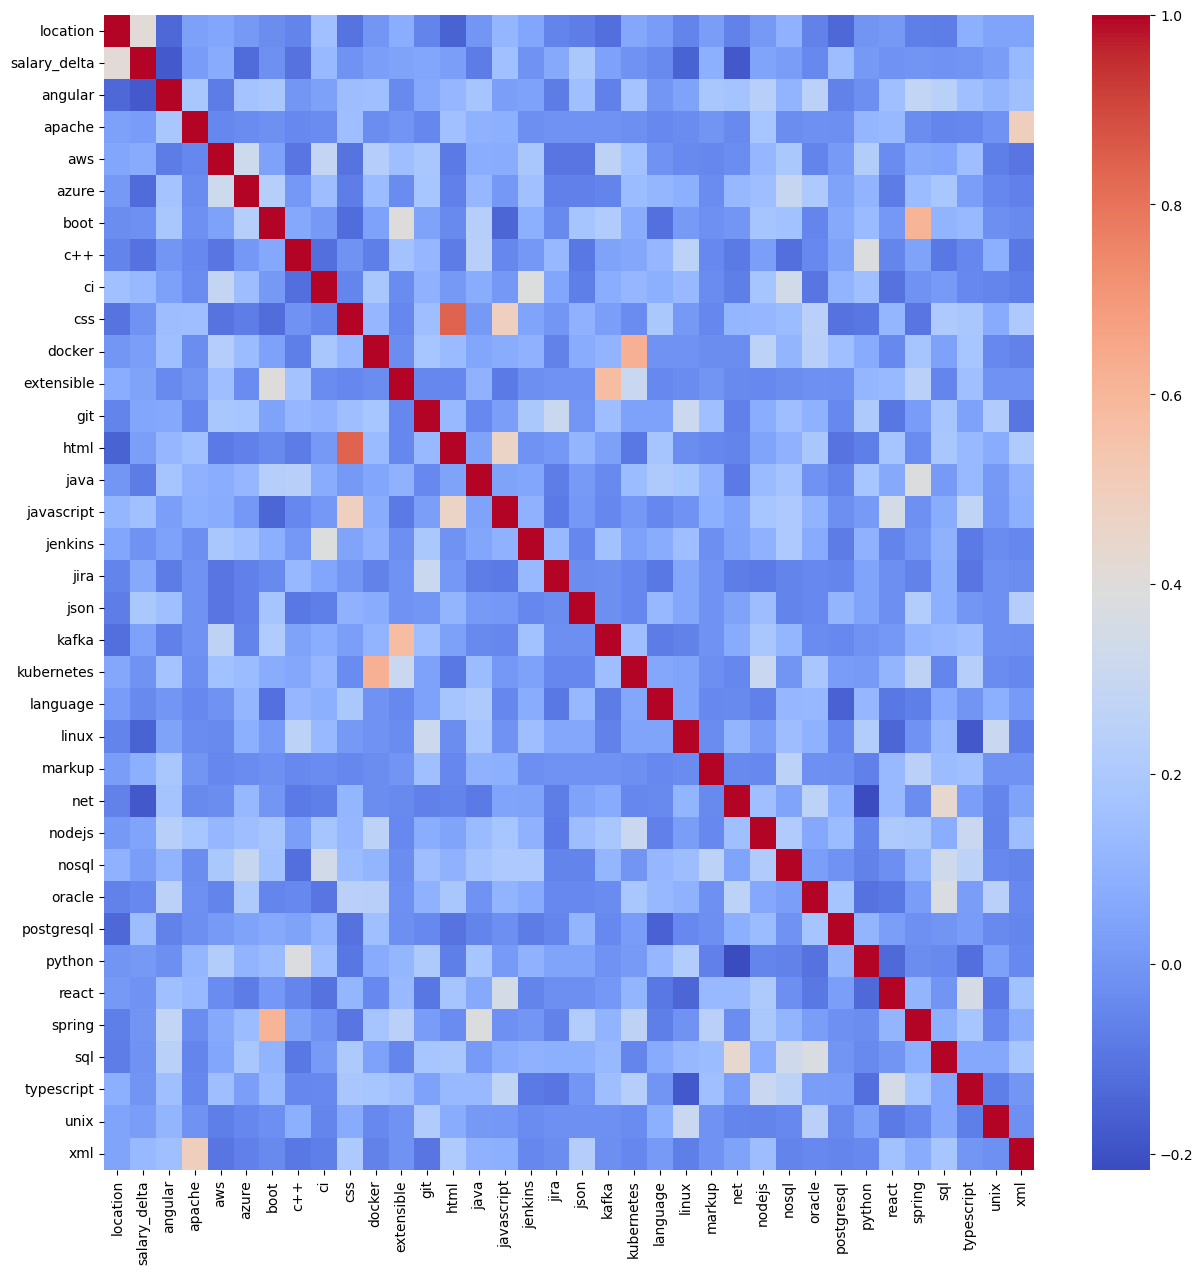

In [259]:

# extract documents that have assigned technical skills
skilled_pos = df[['location','salary_delta','tech_skills']][df['tech_skills'].map(lambda d: len(d)) != 0]

# encode location tags
encoder = LabelEncoder()
skilled_pos['location'] = encoder.fit_transform(skilled_pos['location'])
# scale salary delta from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
skilled_pos['salary_delta'] = scaler.fit_transform(skilled_pos['salary_delta'].to_numpy().reshape(-1, 1))

# One-hot encode the strings
mlb = MultiLabelBinarizer()
encoded_strings = pd.DataFrame(mlb.fit_transform(skilled_pos['tech_skills']), columns=mlb.classes_, index=skilled_pos.index)

# Concatenate the encoded strings with the original DataFrame
df_encoded = pd.concat([skilled_pos[['location', 'salary_delta']], encoded_strings], axis=1)

# Calculate correlation between locations, salaries, and encoded strings
corr_df = df_encoded.corr()


fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_df, annot=False, cmap='coolwarm')

# Soft Skills

In [62]:

# find k most popular n-grams
def most_popular_ngrams(corpus, n, top_k):
    # Create a TfidfVectorizer with n-grams
    params = {
        'ngram_range':n,
        'smooth_idf':True
    }
    vectorizer = TfidfVectorizer(**params)
    
    # get term-document matrix
    tfidf_matrix = vectorizer.fit_transform(corpus)
    smoothed_tfidf = tfidf_matrix.toarray()
    
    # Calculate the average score for each n-gram
    avg_score = np.mean(smoothed_tfidf, axis=0)
    
    # Get the top-k n-grams based on their average TF-IDF scores
    ngrams = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngrams, avg_score), key=lambda x: x[1], reverse=True)[:top_k]
    top_ngrams_list = [ngram for ngram, score in top_ngrams]
    
    return top_ngrams_list, pd.DataFrame(smoothed_tfidf, columns = ngrams)

# get top phrases 
n = 5
top_k = 500

soft_cluster = [' '.join(c) for c in tech_skills_cluster]
popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(soft_cluster, (n,n), top_k)

def most_popular_skills(phrases, skills, n):
    vectorizer = CountVectorizer().fit_transform(phrases + skills)
    similarity_matrix = cosine_similarity(vectorizer)[:len(phrases), len(phrases):]
    
    average_similarities = np.mean(similarity_matrix, axis=0)
    sorted_indices = np.argsort(average_similarities)[::-1]
    
    popular_elements = [skills[i] for i in sorted_indices[:n]]
    return popular_elements

n = 20
most_popular = most_popular_skills(popular_phrases, list(soft_skill_names), n)
print(f'\nTop {n} popular soft skills based on top n-grams: \n{most_popular}\n')

# assign cluster ids to top skills
popular_soft_clusters = [(popular,soft_skills['cluster_id'][soft_skills['skill_name']==popular].item()) 
                         for popular in most_popular]
# make a dict of the skills from csv and their ids
soft_dict = soft_skills[['cluster_id','cluster_representative']
                       ].set_index('cluster_id')['cluster_representative'].to_dict()
# get top soft skill cluster ids and show names
vote_soft_skill = {}
for i,j in popular_soft_clusters:
    if j not in vote_soft_skill:
        vote_soft_skill[j] = 1
    else:
        vote_soft_skill[j] += 1
           
top_soft_skills = sorted(vote_soft_skill, key=lambda x: vote_soft_skill[x], reverse=True)[:3]
print('Top soft skills clusters:')
for it, i in enumerate(top_soft_skills):
    print(f'{it+1}. {soft_dict[i]}')
    


Top 20 popular soft skills based on top n-grams: 
['ability to direct the work', 'ability to plan the work', 'ability to organize the work', 'ability to plan and organize work for others', 'commitment to the wellbeing of children', 'ability to work in team', 'ability to work in a team', 'ability to work and meet deadlines', 'plan the work to carry out a task in time', 'ability to maintain confidentiality of the information', 'able to work in a team', 'ability to work under the pressure', 'ability to complete the tasks to assigned deadlines', 'ability to work as a part of a team', 'ability to work as a part of team', 'ability to work as part of a team', 'ability to foster and maintain a spirit of unity teamwork and cooperation', 'ability to work and communicate with multinational groups', 'able to work as part of a team', 'ability to work in a team environment']

Top soft skills clusters:
1. team player
2. ability to work within deadlines
3. organisational skills
